In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-0c69f5d2-ab21-409f-b579-de79624ec970)


In [2]:
%%capture
!pip install pymort
!pip install matplotlib==3.4.0

In [6]:
from pymort import MortXML
import jax.numpy as jnp
import jax
from jax import random
from typing import List
import matplotlib.pyplot as plt

In [7]:
def timeStep(isAlive, policyAges, mortalityTable, key: random.PRNGKeyArray):
  """Take arrays of policyAges and isAlive, return new array isAlive with 1s for living people"""
  return isAlive * jnp.where(random.uniform(key, shape=isAlive.shape) > mortalityTable[policyAges,], 1, 0)

def timeSteps(issueAges, mortalityTable, timesteps: int, keyInit: int):
  """Run the simulation across"""
  # policy ages are initially the initial ages
  policyAges = issueAges
  # everyone is initially alive, a 1 in the array
  isAlive = jnp.ones(policyAges.shape)
  key = random.PRNGKey(keyInit)
  # store the `isAlive` arrays across timesteps. res[0] is an array with 1 for people alive at t=1 (the end of year 1).
  res = []

  # I had to hardcode the `20` in, can we do this over varying timesteps?
  for t in range(1, 20+1):
    key, subkey = random.split(key)
    isAlive = timeStep(isAlive, policyAges, mortalityTable, subkey)
    policyAges += 1
    res.append(isAlive)
  
  # dimensions are Timesteps X Policies
  return jnp.array(res)

In [8]:
# load the mortality table
xml = MortXML(2581)
mortalityTable = jnp.array(xml.Tables[0].Values.vals)

In [16]:
%%time
vTimeSteps = jax.vmap(timeSteps)

def tileSeveral(size: int, jaxArrays: List[jnp.DeviceArray]):
  """This is a utility function that duplicates arrays so that we can vmap over them"""
  return [jnp.tile(jaxArray, (size, 1)) for jaxArray in jaxArrays]

def makeCube(issueAges: jnp.DeviceArray, timesteps: int, simulations: int):
  """Take in the policies and simulate over the number of timesteps and simulations"""
  vIssueAges, vMortalityTable = tileSeveral(simulations, [issueAges, mortalityTable])
  return vTimeSteps(vIssueAges, vMortalityTable, jnp.ones(simulations)*timesteps, jnp.arange(simulations))


# get the issue ages
key = random.PRNGKey(-24397832879)
key, subkey = random.split(key)
model_points = 1000
issueAges = random.randint(subkey, (model_points,), 70, 85)

timeCube = makeCube(issueAges, 20, 15_000)
portfolioDistribution = jnp.sum(timeCube, axis=(1,2))

# print(timeCube.shape)

CPU times: user 989 ms, sys: 61.9 ms, total: 1.05 s
Wall time: 2.71 s


In [17]:
counts, edges = jnp.histogram(portfolioDistribution)

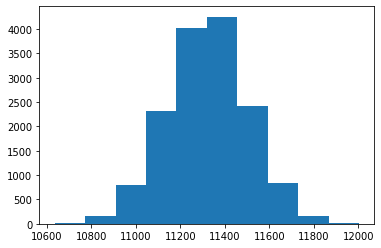

In [18]:
plt.stairs(counts, edges, fill=True)

In [ ]:
# # load the mortality table
# xml = MortXML(2581)
# mortalityTable = jnp.array(xml.Tables[0].Values.vals)

# key = random.PRNGKey(0)
# key, subkey = random.split(key)
# model_points = 1_000
# issue_age = random.randint(subkey, (model_points,), 35, 55)

# # 20 year annuity with constant mortality of .1, each annuity pays 1 dollar a year
# def timeStep(policyAges: jnp.DeviceArray, key: jax.random.PRNGKeyArray):
#   return policies * jnp.where(jax.random.uniform(key, shape=(100,)) > .1, 1, 0)

# def timeSteps(policies: jnp.DeviceArray, keyInit: int):
#   key = jax.random.PRNGKey(keyInit)
#   res = []
#   for t in range(1, 20+1):
#     key, subkey = jax.random.split(key)
#     policies = timeStep(policies, subkey)
#     res.append(policies)
  
#   # dimensions are Timesteps X Policies
#   return jnp.array(res)